In [36]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [37]:
df = pd.read_csv("./ecommerce_sample_data.csv")

In [38]:
df.head()

,customer_id,age,gender,order_id,product_id,category,purchase_amount,order_date,location,payment_method
0,bdd640fb,56,Male,b5ef1ee6-7ff,0f043e7d-c,Toys,1560.01,2025-06-09,Pune,UPI
1,23b8c1e9,46,Male,28a625e1-413,8507eade-6,Home,811.11,2025-02-26,Mumbai,Credit Card
2,bd9c66b3,32,Female,9631be62-13b,cad267b4-0,Toys,83.16,2024-11-15,Delhi,Debit Card
3,972a8469,60,Male,3dc1e882-071,26e25157-b,Books,2650.71,2025-05-18,Pune,Debit Card
4,17fc695a,25,Male,4279dcd6-86e,9ca94273-0,Electronics,2650.51,2025-04-16,Kolkata,Credit Card


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      10000 non-null  object 
 1   age              10000 non-null  int64  
 2   gender           10000 non-null  object 
 3   order_id         10000 non-null  object 
 4   product_id       10000 non-null  object 
 5   category         10000 non-null  object 
 6   purchase_amount  10000 non-null  float64
 7   order_date       10000 non-null  object 
 8   location         10000 non-null  object 
 9   payment_method   10000 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 781.4+ KB


In [40]:
df.isnull().sum()

customer_id        0
age                0
gender             0
order_id           0
product_id         0
category           0
purchase_amount    0
order_date         0
location           0
payment_method     0
dtype: int64

In [41]:
df.duplicated().sum()

np.int64(0)

In [52]:
for i in df.columns:
    print(i,len(df[i].unique()))

customer_id 10000
age 47
gender 3
order_id 10000
product_id 10000
category 6
purchase_amount 9798
order_date 366
location 8
payment_method 6


#### Clean missing values, convert order_date to datetime, standardize categorical variables. 

In [43]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [44]:
df['category'] = df['category'].str.title().str.strip()
df['payment_method'] = df['payment_method'].str.title().str.strip()

In [45]:
df['category'].unique()

array(['Toys', 'Home', 'Books', 'Electronics', 'Beauty', 'Clothing'],
      dtype=object)

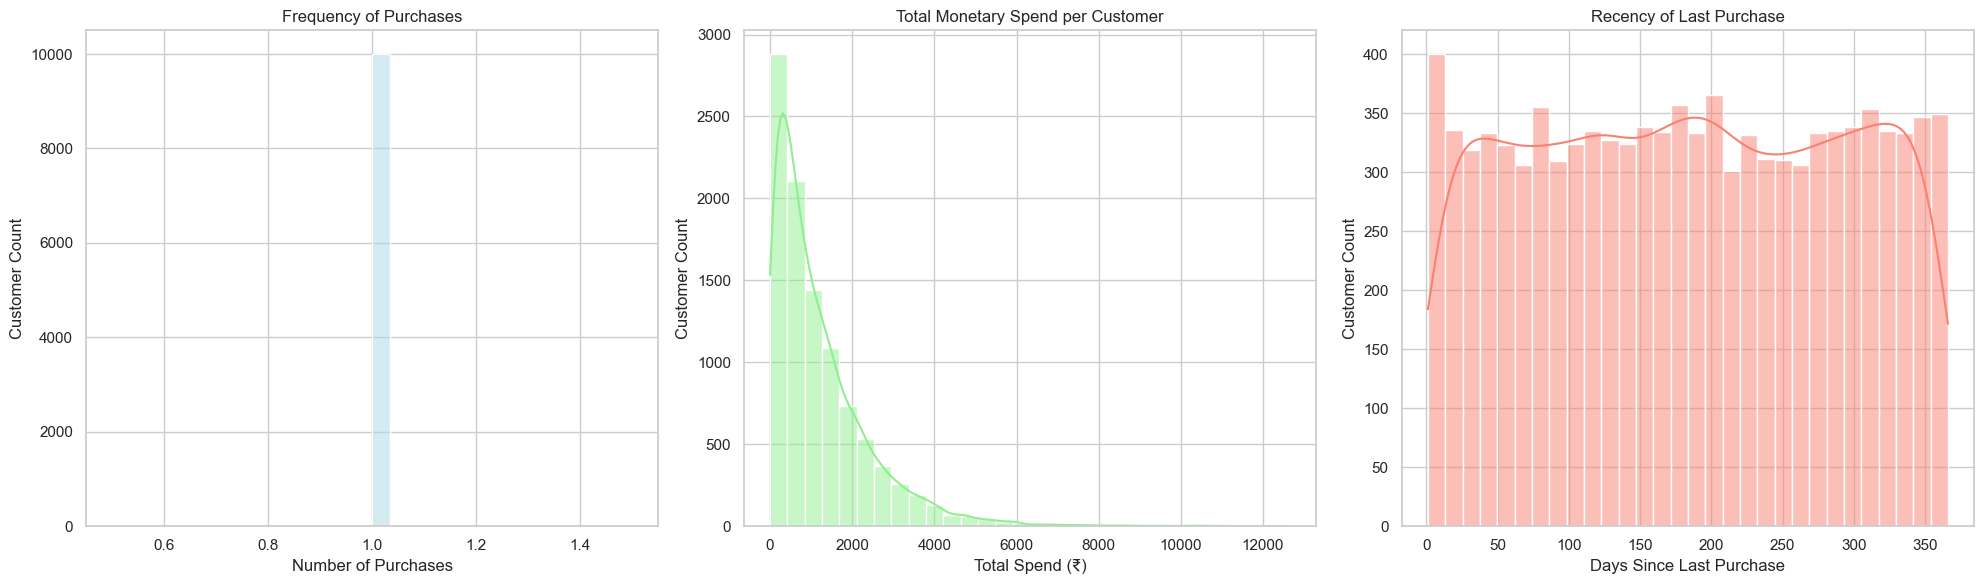

In [49]:
# Reference date for Recency
reference_date = df['order_date'].max() + timedelta(days=1)

# RFM Aggregation
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (reference_date - x.max()).days,  # Recency
    'order_id': 'count',                                      # Frequency
    'purchase_amount': 'sum'                                  # Monetary
}).rename(columns={
    'order_date': 'Recency',
    'order_id': 'Frequency',
    'purchase_amount': 'Monetary'
})


# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Frequency Plot
sns.histplot(rfm['Frequency'], bins=30, kde=True, ax=axes[0], color='lightblue')
axes[0].set_title('Frequency of Purchases')
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Customer Count')

# Monetary Plot
sns.histplot(rfm['Monetary'], bins=30, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Total Monetary Spend per Customer')
axes[1].set_xlabel('Total Spend (₹)')
axes[1].set_ylabel('Customer Count')

# Recency Plot
sns.histplot(rfm['Recency'], bins=30, kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Recency of Last Purchase')
axes[2].set_xlabel('Days Since Last Purchase')
axes[2].set_ylabel('Customer Count')

plt.tight_layout()
plt.show()


In [50]:
rfm

,Recency,Frequency,Monetary
customer_id,,,
000cd21a,337,1,329.06
001e7006,72,1,270.65
00231f70,242,1,1822.57
0029691e,8,1,1142.13
002f4aee,188,1,1275.10
...,...,...,...
ffdf6588,294,1,3970.89
fff03027,30,1,199.55
fff446b9,299,1,3173.79


C:\Users\daksh\AppData\Local\Temp\ipykernel_31112\4228689841.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_monetary = rfm.groupby('Segment')['Monetary'].sum()
C:\Users\daksh\AppData\Local\Temp\ipykernel_31112\4228689841.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, ax=axes[0], palette='Set2')
C:\Users\daksh\AppData\Local\Temp\ipykernel_31112\4228689841.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_monetary.index, y=

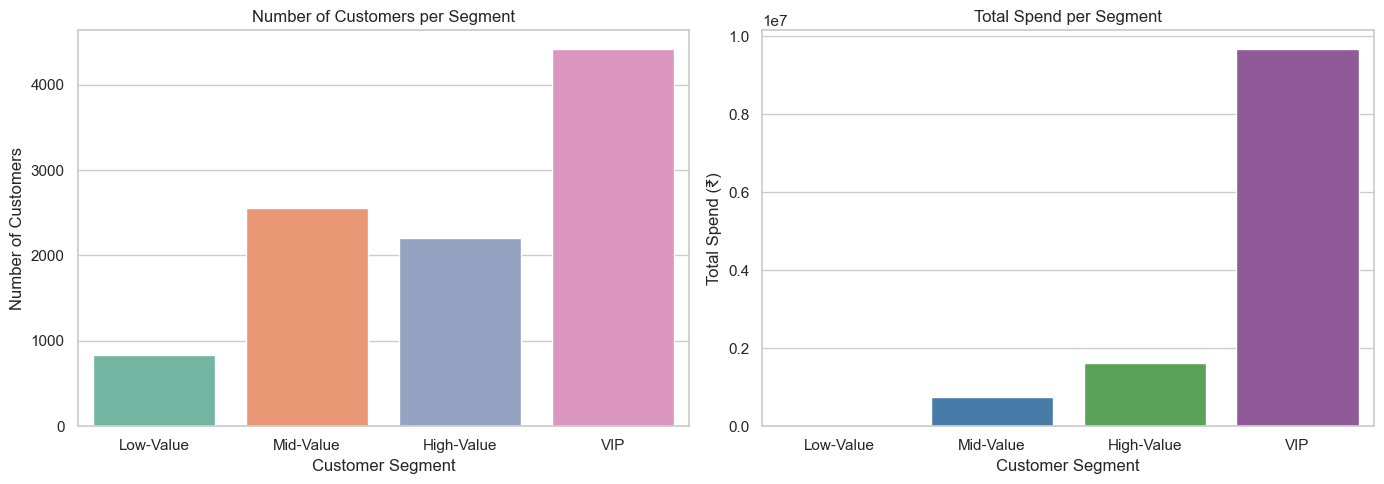

In [47]:
rfm['Segment'] = pd.cut(rfm['Monetary'], 
                        bins=[0, 100, 500, 1000, float('inf')], 
                        labels=['Low-Value', 'Mid-Value', 'High-Value', 'VIP'])

segment_counts = rfm['Segment'].value_counts().sort_index()

segment_monetary = rfm.groupby('Segment')['Monetary'].sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=segment_counts.index, y=segment_counts.values, ax=axes[0], palette='Set2')
axes[0].set_title('Number of Customers per Segment')
axes[0].set_xlabel('Customer Segment')
axes[0].set_ylabel('Number of Customers')

sns.barplot(x=segment_monetary.index, y=segment_monetary.values, ax=axes[1], palette='Set1')
axes[1].set_title('Total Spend per Segment')
axes[1].set_xlabel('Customer Segment')
axes[1].set_ylabel('Total Spend (₹)')

plt.tight_layout()
plt.show()


In [48]:
gender, category, location, payment_method -> Category


SyntaxError: invalid syntax (231463346.py, line 1)

In [ ]:
['Pune' 'Mumbai' 'Delhi' 'Kolkata' 'Hyderabad' 'Chennai' 'Ahmedabad'
 'Bangalore']
['UPI' 'Credit Card' 'Debit Card' 'Wallet' 'Net Banking'
 'Cash on Delivery']

['UPICredit CardDebit CardWalletNet BankingCash on Delivery']

In [ ]:
['Male' 'Female' 'Other']

In [ ]:
pd.qcut(df['purchase_amount'], q=4, labels=["Low", "Mid", "High", "Top"])

0       High
1        Mid
2        Low
3        Top
4        Top
        ... 
9995     Top
9996     Low
9997     Low
9998    High
9999    High
Name: purchase_amount, Length: 10000, dtype: category
Categories (4, object): ['Low' < 'Mid' < 'High' < 'Top']

C:\Users\daksh\AppData\Local\Temp\ipykernel_31112\1275331860.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_pref = df.groupby(['Segment', 'category']).size().unstack(fill_value=0)
C:\Users\daksh\AppData\Local\Temp\ipykernel_31112\1275331860.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payment_by_age = df.groupby(['age_group', 'payment_method']).size().unstack(fill_value=0)


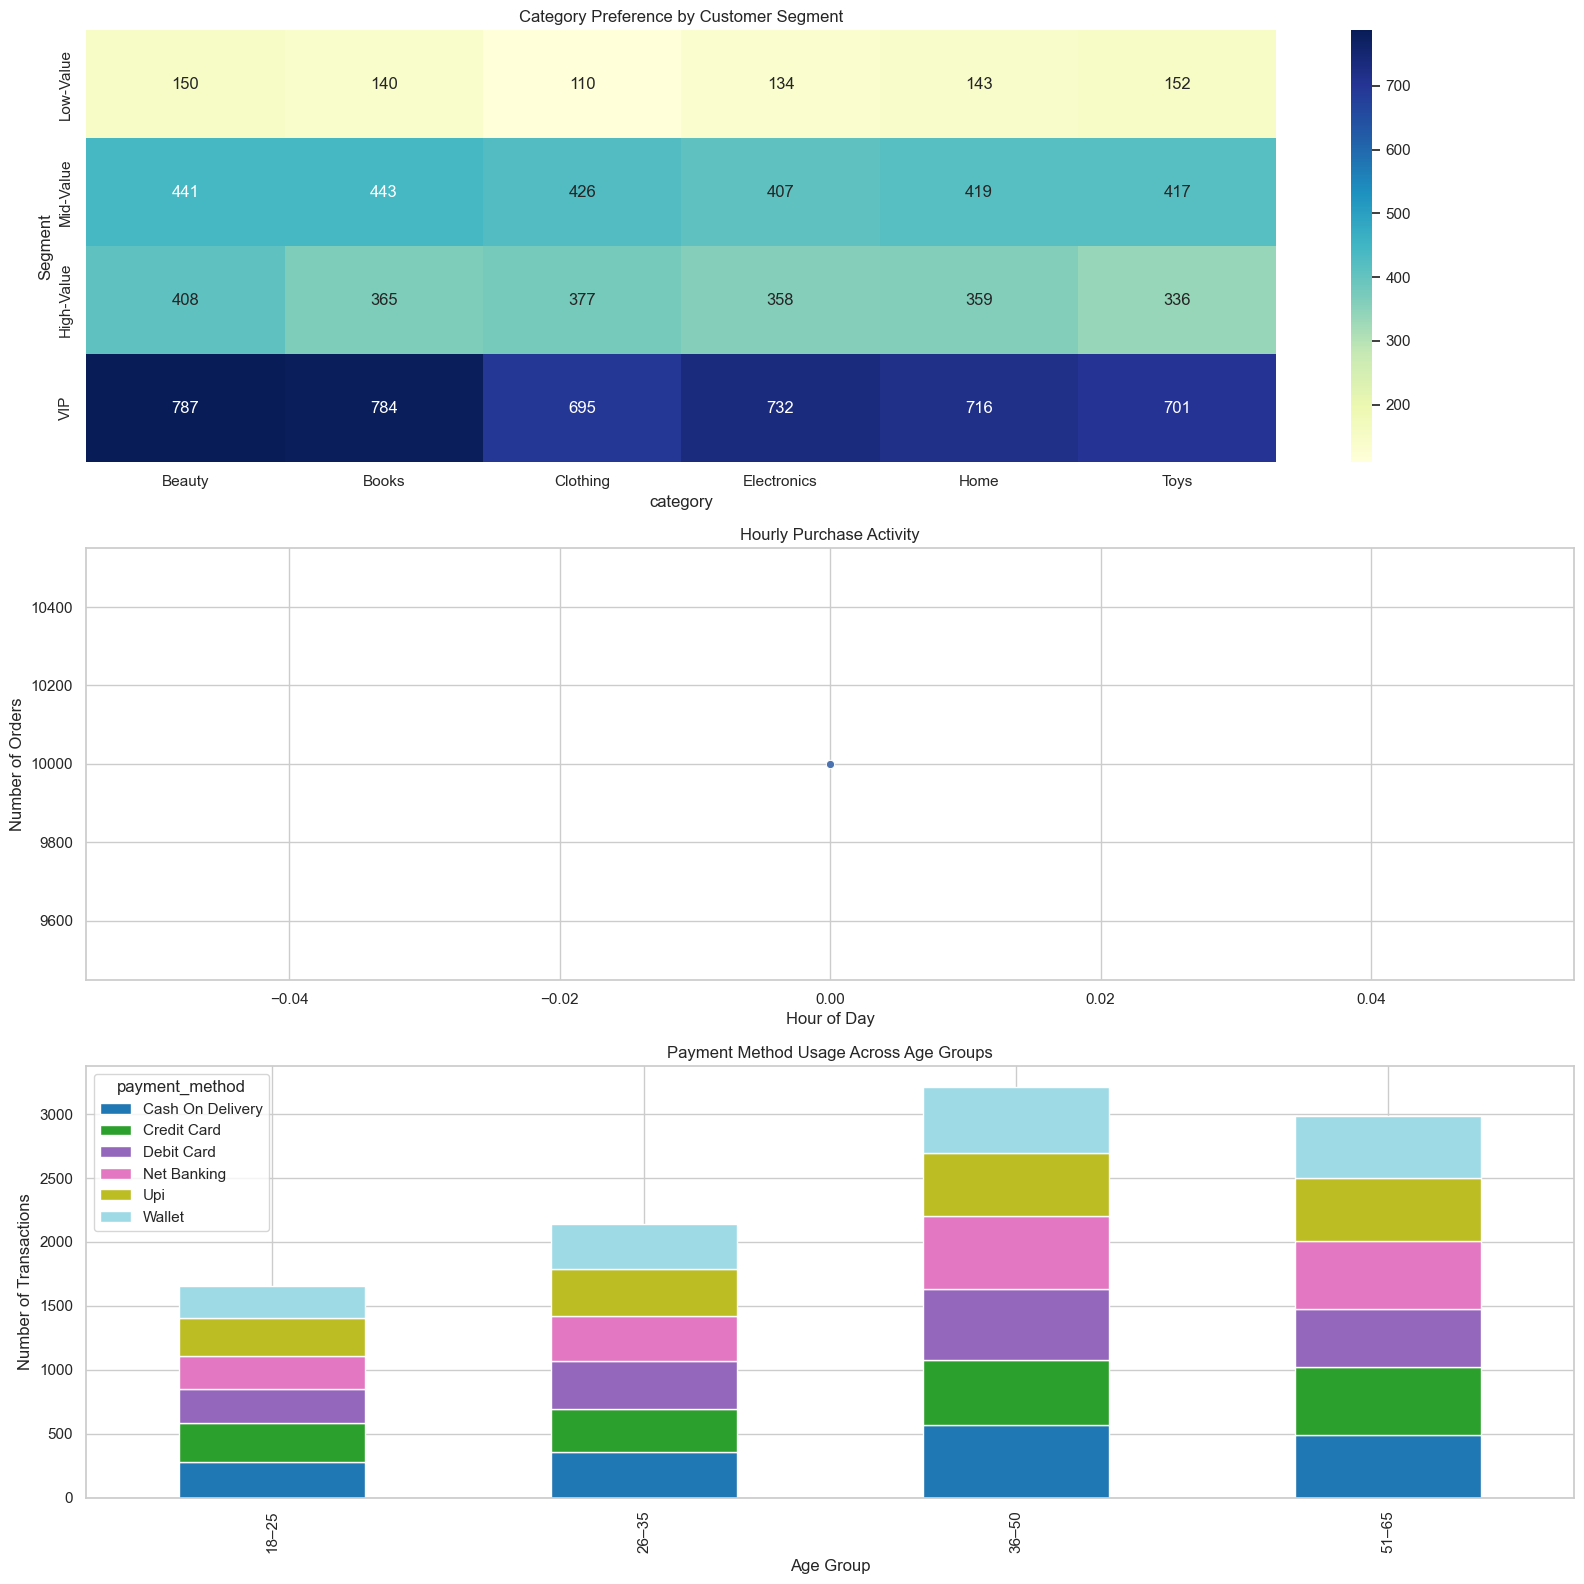

In [53]:
df['hour'] = df['order_date'].dt.hour

df = df.merge(rfm[['Recency', 'Frequency', 'Monetary']], on='customer_id')
df['Segment'] = pd.cut(df['Monetary'], 
                       bins=[0, 100, 500, 1000, float('inf')], 
                       labels=['Low-Value', 'Mid-Value', 'High-Value', 'VIP'])

# --- 1. Category preference by Segment ---
category_pref = df.groupby(['Segment', 'category']).size().unstack(fill_value=0)

# --- 2. Peak Buying Hour ---
hourly_activity = df.groupby('hour')['order_id'].count()

# --- 3. Payment Method Usage Across Age Groups (binning age) ---
df['age_group'] = pd.cut(df['age'], bins=[17, 25, 35, 50, 65], 
                         labels=["18–25", "26–35", "36–50", "51–65"])
payment_by_age = df.groupby(['age_group', 'payment_method']).size().unstack(fill_value=0)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(16, 16))

# 1. Category Preference by Segment (heatmap)
sns.heatmap(category_pref, annot=True, fmt='d', cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Category Preference by Customer Segment")

# 2. Hourly Purchase Distribution
sns.lineplot(x=hourly_activity.index, y=hourly_activity.values, marker='o', ax=axes[1])
axes[1].set_title("Hourly Purchase Activity")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Number of Orders")

# 3. Payment Method by Age Group (stacked bar chart)
payment_by_age.plot(kind='bar', stacked=True, ax=axes[2], colormap="tab20")
axes[2].set_title("Payment Method Usage Across Age Groups")
axes[2].set_xlabel("Age Group")
axes[2].set_ylabel("Number of Transactions")

plt.tight_layout()
plt.show()


In [56]:
df

,customer_id,age,gender,order_id,product_id,category,purchase_amount,order_date,location,payment_method,hour,Recency,Frequency,Monetary,Segment,age_group
0,bdd640fb,56,Male,b5ef1ee6-7ff,0f043e7d-c,Toys,1560.01,2025-06-09,Pune,Upi,0,19,1,1560.01,VIP,51–65
1,23b8c1e9,46,Male,28a625e1-413,8507eade-6,Home,811.11,2025-02-26,Mumbai,Credit Card,0,122,1,811.11,High-Value,36–50
2,bd9c66b3,32,Female,9631be62-13b,cad267b4-0,Toys,83.16,2024-11-15,Delhi,Debit Card,0,225,1,83.16,Low-Value,26–35
3,972a8469,60,Male,3dc1e882-071,26e25157-b,Books,2650.71,2025-05-18,Pune,Debit Card,0,41,1,2650.71,VIP,51–65
4,17fc695a,25,Male,4279dcd6-86e,9ca94273-0,Electronics,2650.51,2025-04-16,Kolkata,Credit Card,0,73,1,2650.51,VIP,18–25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,f3986f93,33,Male,d892f59b-a47,addfe2fe-d,Electronics,3147.51,2025-06-07,Delhi,Net Banking,0,21,1,3147.51,VIP,26–35
9996,507409da,29,Female,65123e60-ed9,51dadd61-3,Toys,284.71,2024-07-06,Delhi,Wallet,0,357,1,284.71,Mid-Value,26–35
9997,bce4d414,18,Male,e1e54c0b-753,0a6099e4-d,Toys,106.36,2024-10-02,Ahmedabad,Cash On Delivery,0,269,1,106.36,Mid-Value,18–25
9998,0eca3630,25,Female,9683db86-23a,d26e045e-6,Clothing,936.00,2025-06-22,Ahmedabad,Debit Card,0,6,1,936.00,High-Value,18–25


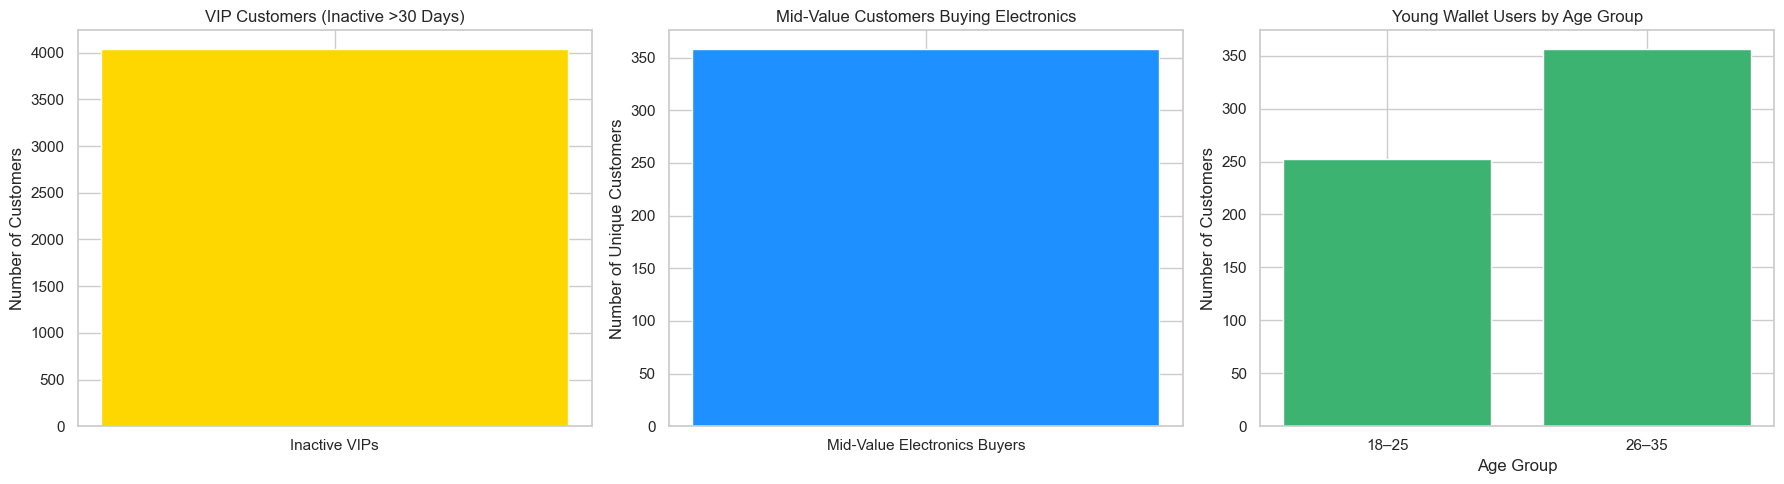

In [58]:
# Prepare data for visualization of the 3 insights

# 1. VIP Customers who haven’t purchased recently
vip_inactive = rfm[(rfm['Monetary'] > 1000) & (rfm['Recency'] > 30)]

# 2. Mid-value customers who buy electronics
mid_value_customers = df[(df['Monetary'].between(500, 1000))]
mid_electronics = mid_value_customers[mid_value_customers['category'] == 'Electronics']

# 3. Younger customers using wallets
young_wallet_users = df[(df['age'].between(18, 35)) & (df['payment_method'] == 'Wallet')]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: VIP Inactive Count
axes[0].bar(['Inactive VIPs'], [vip_inactive.shape[0]], color='gold')
axes[0].set_title('VIP Customers (Inactive >30 Days)')
axes[0].set_ylabel('Number of Customers')

# Plot 2: Mid-Value + Electronics Buyers
axes[1].bar(['Mid-Value Electronics Buyers'], [mid_electronics['customer_id'].nunique()], color='dodgerblue')
axes[1].set_title('Mid-Value Customers Buying Electronics')
axes[1].set_ylabel('Number of Unique Customers')

# Plot 3: Wallet Users (Young Age)
young_age_group_counts = young_wallet_users['age'].apply(
    lambda x: '18–25' if x <= 25 else '26–35').value_counts().sort_index()
axes[2].bar(young_age_group_counts.index, young_age_group_counts.values, color='mediumseagreen')
axes[2].set_title('Young Wallet Users by Age Group')
axes[2].set_ylabel('Number of Customers')
axes[2].set_xlabel('Age Group')

plt.tight_layout()
plt.show()
